<ipython-input-3-fc7a9abd1d03>:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter
<ipython-input-3-fc7a9abd1d03>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weight

Original Image


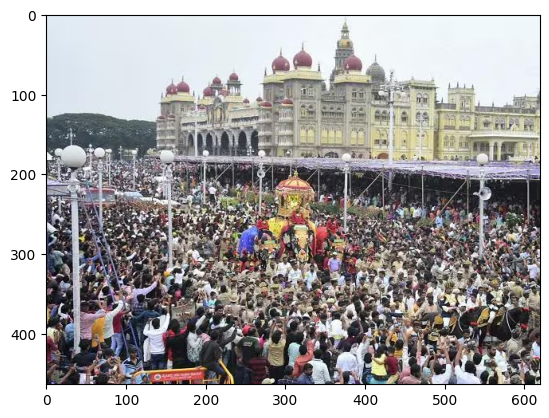

Predicted Count :  712


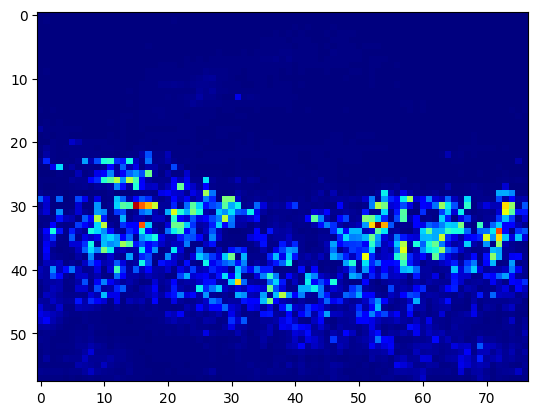

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
from matplotlib import pyplot as plt, cm as c
from scipy.ndimage.filters import gaussian_filter
import scipy
import torchvision.transforms.functional as F

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        if not load_weights:
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


model = CSRNet()


checkpoint = torch.load('/content/Weights (2).pth', map_location="cpu")
model.load_state_dict(checkpoint)


img_path = "/content/dasara.jpeg"


print("Original Image")
plt.imshow(plt.imread(img_path))
plt.show()


img = transform(Image.open(img_path).convert('RGB'))


output = model(img.unsqueeze(0))


print("Predicted Count : ", int(output.detach().cpu().sum().numpy()))

temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2], output.detach().cpu().shape[3]))
plt.imshow(temp, cmap=c.jet)
plt.show()
